In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score


In [2]:
datos = pd.read_excel("bank-full.xlsx")
datos.head()

,ID client,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,1,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,2,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,3,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,4,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,5,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
datos_filtrados = datos[(datos['loan'] == 'no') & (datos['housing'] == 'no')]
y = datos_filtrados.groupby('age').size()
X = datos_filtrados[["age", "balance", "duration", "campaign"]]

In [4]:
# Filtrar los datos para clientes sin préstamos personales ni hipotecarios
datos_filtrados = datos[(datos['loan'] == 'no') & (datos['housing'] == 'no')]

# Agrupar datos filtrados por edad y contar cantidad de clientes
datos_agrupados = datos_filtrados.groupby('age').size()

# Crear DataFrame con las variables predictoras y la variable de respuesta
datos_regresion_multiple = pd.DataFrame({
    'age': datos_agrupados.index,
    'balance': datos_filtrados.groupby('age')['balance'].sum(),
    'duration': datos_filtrados.groupby('age')['duration'].mean(),
    'campaign': datos_filtrados.groupby('age')['campaign'].mean(),
    'y': datos_agrupados.values
})

#datos_regresion_multiple.reset_index(drop=True, inplace=True)


# Definir variables X (predictoras) y Y (respuesta) para la regresión múltiple
X = sm.add_constant(datos_regresion_multiple[['age', 'balance', 'duration', 'campaign']])
y = datos_regresion_multiple['y']

In [5]:
datos_regresion_multiple

,age,balance,duration,campaign,y
age,,,,,
18,18,4469,214.166667,1.750000,12
19,19,18892,175.485714,2.914286,35
20,20,33459,208.111111,1.916667,36
21,21,53707,229.056604,1.849057,53
22,22,67620,220.812500,1.812500,64
...,...,...,...,...,...
90,90,713,354.500000,2.000000,2
92,92,1550,238.500000,3.500000,2
93,93,1550,668.000000,2.000000,2


In [6]:
def stepwise(datos, y):
    # Eliminar filas con NaN para evitar problemas con el ajuste del modelo
    datos = datos.dropna()

    # Definir las variables predictoras X y la variable de respuesta y
    X = datos.drop(columns=[y])
    y = datos[y]

    variables_seleccionadas = []
    variables_restantes = list(X.columns)
    mejor_adj_r2 = -float("inf")
    num_variables = len(X.columns)

    # Paso 1: Modelo con solo la ordenada al origen
    reg_nulo = LinearRegression().fit(np.ones((len(X), 1)), y)
    rss_nulo = np.sum((y - reg_nulo.predict(np.ones((len(X), 1)))) ** 2)
    aic_nulo = len(y) * np.log(rss_nulo / len(y)) + 2  # AIC = n * log(RSS/n) + 2 * p (p = 1)
    adj_r2_nulo = 1 - (1 - reg_nulo.score(np.ones((len(X), 1)), y)) * ((len(y) - 1) / (len(y) - 1))

    print("Paso 1: Modelo con ordenada al origen")
    print(f"R-cuadrado ajustado: {adj_r2_nulo}")
    print(f"AIC: {aic_nulo}")
    print("------")

    for _ in range(num_variables):
        mejor_r2 = -float("inf")
        mejor_variable = None
        mejor_temp_adj_r2 = -float("inf")
        mejor_temp_aic = float("inf")

        for variable in variables_restantes:
            variables_actuales = variables_seleccionadas + [variable]
            X_subset = X[variables_actuales]
            reg_temp = LinearRegression()
            reg_temp.fit(X_subset, y)
            r2 = reg_temp.score(X_subset, y)

            if r2 > mejor_r2:
                mejor_r2 = r2
                mejor_variable = variable

                # Calcular el R-cuadrado ajustado temporal
                n = len(y)
                p = len(variables_actuales)
                temp_adj_r2 = 1 - (1 - mejor_r2) * ((n - 1) / (n - p - 1))

                # Calcular el AIC temporal
                rss = np.sum((y - reg_temp.predict(X_subset)) ** 2)
                temp_aic = n * np.log(rss / n) + 2 * p

                if temp_adj_r2 > mejor_temp_adj_r2:
                    mejor_temp_adj_r2 = temp_adj_r2
                    mejor_temp_aic = temp_aic

        variables_seleccionadas.append(mejor_variable)
        variables_restantes.remove(mejor_variable)

        X_seleccionado = X[variables_seleccionadas]
        reg_seleccionado = LinearRegression()
        reg_seleccionado.fit(X_seleccionado, y)
        adj_r2 = mejor_temp_adj_r2
        aic = mejor_temp_aic

        if adj_r2 > mejor_adj_r2:
            mejor_adj_r2 = adj_r2
            mejores_variables_seleccionadas = variables_seleccionadas.copy()

        # Crear un diccionario que mapea cada variable a su coeficiente
        coeficientes = dict(zip(variables_seleccionadas, reg_seleccionado.coef_))

        print(f"Paso {_ + 2}: Variable agregada: {mejor_variable}")
        print(f"R-cuadrado ajustado: {adj_r2}")
        print(f"AIC: {aic}")
        print(f"Ordenada al origen: {reg_seleccionado.intercept_}")  # Imprime la ordenada al origen
        print(f"Coeficientes: {coeficientes}")  # Imprime los coeficientes del modelo en este paso
        print("------")

    print("Método Stepwise Forward:")
    print("Variables seleccionadas:", mejores_variables_seleccionadas)
    print("Mejor R-cuadrado ajustado:", mejor_adj_r2)
    print("Ordenada al origen:", reg_seleccionado.intercept_)  # Imprime la ordenada al origen del modelo final
    print("Coeficientes:", coeficientes)  # Imprime los coeficientes del modelo final

    return mejores_variables_seleccionadas, mejor_adj_r2, aic, reg_seleccionado.intercept_, coeficientes


In [7]:
stepwise(datos_regresion_multiple, "y")

Paso 1: Modelo con ordenada al origen
R-cuadrado ajustado: 0.0
AIC: 828.8129616985808
------
Paso 2: Variable agregada: balance
R-cuadrado ajustado: 0.9181030104758554
AIC: 635.1165146394137
Ordenada al origen: -2.35277787789974
Coeficientes: {'balance': 0.0005815644728505877}
------
Paso 3: Variable agregada: age
R-cuadrado ajustado: 0.9349182731812891
AIC: 618.3869240069644
Ordenada al origen: 98.20515814510837
Coeficientes: {'balance': 0.0005348783764450494, 'age': -1.4706526641911708}
------
Paso 4: Variable agregada: campaign
R-cuadrado ajustado: 0.9356599064227995
AIC: 618.4568041528132
Ordenada al origen: 83.05231375944888
Coeficientes: {'balance': 0.0005246258447285961, 'age': -1.5456086918912555, 'campaign': 9.223925387855527}
------
Paso 5: Variable agregada: duration
R-cuadrado ajustado: 0.9347938499059755
AIC: 620.4242710922745
Ordenada al origen: 80.00751938757
Coeficientes: {'balance': 0.0005251031652066565, 'age': -1.5684236608393007, 'campaign': 9.25004722242838, 'durat

(['balance', 'age', 'campaign'],
 0.9356599064227995,
 620.4242710922745,
 80.00751938757,
 {'balance': 0.0005251031652066565,
  'age': -1.5684236608393007,
  'campaign': 9.25004722242838,
  'duration': 0.0140450994948773})

In [9]:
stepwise(datos_regresion_multiple, "y")

Paso 2: Variable agregada: balance
R-cuadrado ajustado: 0.9181030104758554
AIC: 855.6330487529333
p-valor del F-test: 1.0294427001340735e-42
Coeficientes: {'intercept': -2.352777877899747, 'balance': 0.000581564472850588}
------
Paso 3: Variable agregada: age
R-cuadrado ajustado: 0.9349182731812891
AIC: 838.903458120484
p-valor del F-test: 4.6714985289168425e-45
Coeficientes: {'intercept': 98.20515814510827, 'balance': 0.0005348783764450494, 'age': -1.4706526641911697}
------
Paso 4: Variable agregada: campaign
R-cuadrado ajustado: 0.9356599064227994
AIC: 838.9733382663328
p-valor del F-test: 4.962740389766104e-44
Coeficientes: {'intercept': 83.05231375944892, 'balance': 0.0005246258447285959, 'age': -1.5456086918912555, 'campaign': 9.223925387855555}
------
Paso 5: Variable agregada: duration
R-cuadrado ajustado: 0.9347938499059755
AIC: 840.940805205794
p-valor del F-test: 1.0241177638702356e-42
Coeficientes: {'intercept': 80.00751938756987, 'balance': 0.0005251031652066569, 'age': -1

(['balance', 'age', 'campaign'],
 0.9356599064227994,
 840.940805205794,
 {'intercept': 80.00751938756987,
  'balance': 0.0005251031652066569,
  'age': -1.568423660839346,
  'campaign': 9.250047222428398,
  'duration': 0.014045099494886179})

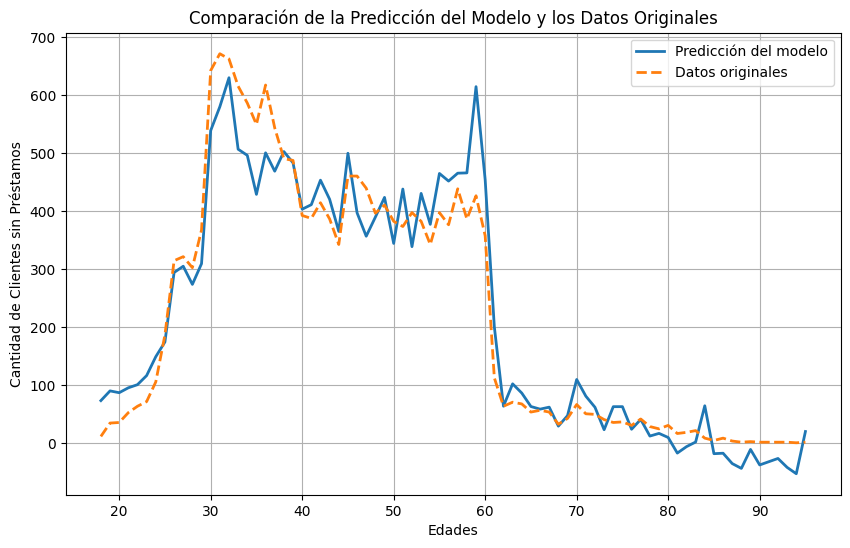

In [10]:
# Coeficientes del modelo
coef = [0.0005246258447285961, -1.5456086918912555, 9.223925387855527]

# Calcular los valores predichos por el modelo
datos_regresion_multiple['resultado_regresion'] = 83.05231375944888 + datos_regresion_multiple['balance']*coef[0] + datos_regresion_multiple['age']*coef[1] + datos_regresion_multiple['campaign']*coef[2]

# Crear el gráfico
plt.figure(figsize=(10, 6))  # Ajustar el tamaño del gráfico
plt.plot(datos_regresion_multiple['resultado_regresion'], label='Predicción del modelo', linewidth=2)
plt.plot(datos_regresion_multiple['y'], label='Datos originales', linewidth=2, linestyle='--')
plt.title('Comparación de la Predicción del Modelo y los Datos Originales')  # Título del gráfico
plt.xlabel('Edades')  # Etiqueta del eje x
plt.ylabel('Cantidad de Clientes sin Préstamos')  # Etiqueta del eje y
plt.legend()  # Mostrar la leyenda
plt.grid(True)  # Añadir una cuadrícula
plt.show()